Political stance classification

We will implement a system to carry out a document classification task. The documents have been harvested by students from various social media platforms (mainly comments from YouTube). Each document has been annotated (also by students) for whether it is positive or negative towards [Brexit](https://en.wikipedia.org/wiki/Brexit) (the UK leaving the European Union).

The pedagical point of this assignment is not so much about the task of document classification, or about the design of neural network solutions for this task. (This will be discussed in more detail in lecture sessions.) Instead, most of your work here is intended to make sure you understand the *practical* side of working with PyTorch for NLP tasks.

Most of your work will be the implementation of
- *preprocessing* utlities to convert the text into a numerical format that can be used by PyTorch,
- the *training loop* that takes an untrained model, applies it to a training set, and updates the model.

# Preliminaries

To run the code, the following libraries need to be installed on your machine:

- [PyTorch](https://pytorch.org/) is the machine learning library we will use. You can see on the PyTorch home page how to install the library.
- [scikit-learn](https://scikit-learn.org/) for a couple of minor utility functions.
- [spaCy](https://spacy.io/) for basic linguistic preprocessing.
- [pandas](https://pandas.pydata.org/) to read the files.
- [tqdm](https://tqdm.github.io/) for a progress bar used in the training loop.
- [NumPy](https://numpy.org/) to combine some matrices in the final part of the assignment.

If you use Colab, nothing needs to be installed since all libraries are included in the standard setup.

PyTorch is mandatory for this assignment, but the other libraries are simply for convenience and you can solve the assignment without them (if for some reason you don't want to install the libraries).

Download the training and test files from [this directory](http://www.cse.chalmers.se/~richajo/dat450/assignments/data/). Place them in some directory where this notebook can access them.

In [ ]:
# The following shell commands will download the training and test files to your Colab runtime.
!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/data/brexit_train.tsv
!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/data/brexit_test.tsv

--2022-11-07 09:36:49--  http://www.cse.chalmers.se/~richajo/dat450/assignments/data/brexit_train.tsv
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.221.33
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1798423 (1.7M) [text/tab-separated-values]
Saving to: ‘brexit_train.tsv’

brexit_train.tsv    100%[===================>]   1.71M   663KB/s    in 2.7s    

2022-11-07 09:36:52 (663 KB/s) - ‘brexit_train.tsv’ saved [1798423/1798423]

--2022-11-07 09:36:52--  http://www.cse.chalmers.se/~richajo/dat450/assignments/data/brexit_test.tsv
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.221.33
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157964 (154K) [text/tab-separated-values]
Saving to: ‘brexit_test.tsv’

brexit_test.tsv     100%[===================>] 154.26K   221KB/s    i

### Reading the data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

We use Pandas to read the file containing the training data. It consists of two tab-separated columns, where the first column contains the gold-standard labels and the second contains the text

In [ ]:
train_corpus = pd.read_csv('brexit_train.tsv', sep='\t', header=0, names=['label', 'text'])

Here, we can see the first few instances.

In [ ]:
train_corpus.head()

,label,text
0,anti,Brexit is bad. Immigrants make Britain great. ...
1,anti,Britain is basically Pompeii if the Pompeii ha...
2,pro,Britain's exit is a huge blow to the dream of ...
3,pro,"Death to the EU, Death to the EU!"
4,pro,Europe Union 'lost' Britain. is more accurate....


We split the data into a training (80%) and a validation part (20%). We use the convenience function `train_test_split` from scikit-learn.

Following standard notation, we refer to the input part of the data (that is, the documents) as `X` and the output part (classification labels) as `Y`.

The validation will be used to compute diagnostic scores during training.

In [ ]:
Xtrain, Xval, Ytrain, Yval = train_test_split(train_corpus.text, train_corpus.label, test_size=0.2, random_state=0)

### Tokenization

The task of splitting a text into a sequence of symbols (*tokens*) is called *tokenization*. Classically, the tokens correspond to words and punctuation symbols. However, later in the course, we will see alternatives to word-based tokenization.

We will not build our own tokenizer, but instead use the tokenizer for English built into the `spacy` library.

**Please note**: the first time you use spaCy with some language (English in our case), you need to install a module for that language. See [here](https://spacy.io/usage/models) for a description of how to do this. In short, you typically need to run a command in a shell such as

```
python -m spacy download en_core_web_sm
```
Colab users don't need to carry out this step, since spaCy and the English module are already installed by default.

When the English module is downloaded, we can load it as follows:

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

Now, we have what we need to do tokenization of English texts. 

For your convenience, the function below calls the spaCy tokenizer and extracts the token strings. Optionally, we also apply lowercase normalization to the strings.

In [ ]:
def tokenize(text, lowercase=True):
    if lowercase:
        return [t.text.lower() for t in nlp.tokenizer(text)]
    else:
        return [t.text for t in nlp.tokenizer(text)]

Let's apply the tokenization function to an example.

In [ ]:
tokenize('[12345/689-123] L. Ron Hubbard went to the U.S... "He joined the U.S. Army!!!"')

['[',
 '12345/689',
 '-',
 '123',
 ']',
 'l.',
 'ron',
 'hubbard',
 'went',
 'to',
 'the',
 'u.s',
 '...',
 '"',
 'he',
 'joined',
 'the',
 'u.s.',
 'army',
 '!',
 '!',
 '!',
 '"']

### Example: how to find the most frequent words in a dataset

When you implement the vocabulary processing below, you will need to compute word frequencies. This can of course be done using standard Python data structures, but the easiest approach is probably to use the specialized dictionary type called [`Counter`](https://docs.python.org/3/library/collections.html#collections.Counter). As the name suggests, this is used in Python when counting things.

Here are a few idioms showing how to use the `Counter`. The examples show three different ways to compute the frequencies.

In [ ]:
from collections import Counter

freqs = Counter()
for x in Xtrain:
    for t in tokenize(x):
        freqs[t] += 1

#freqs = Counter()
#for x in Xtrain:
#    freqs.update(tokenize(x))

#freqs = Counter(t for x in Xtrain for t in tokenize(x))

After building the `Counter`, we have a data structure where each word is mapped to a frequency count.

We can then use the method `most_common` to find the items in the dictionary that have the highest frequencies. This method returns a sorted list of item/frequency pairs.

In [ ]:
for word, freq in freqs.most_common(10):
    print(word, freq)

the 15268
. 12874
, 8001
to 7661
and 6388
of 5393
a 5284
is 4329
eu 3819
it 3671


# Part 1: Preprocessing documents

Now, we are ready to implement the utilities we need in order to preprocess documents for machine learning with PyTorch.

Your implementation will be done in this class `DocumentPreprocessor`. *Please note* that there are some tests below that check whether you seem to have implemented the methods correctly. If you want, you can work incrementally, so that you make sure that your tests run before moving on to the next step.

**Your work:**

**1)** Implement the method `build_vocab`. 

This method takes a training set (inputs `X` and outputs `Y`) and builds two vocabularies, one for the words in the input documents and one for the output labels. These vocabularies are data structures that allow you to map a string to a corresponding integer index.

**Requirements:**
- The special symbols `PAD` and `UNKNOWN` should correspond to the encoded values 0 and 1, respectively.
- The size of the resulting vocabulary should be at most `max_voc_size`, if the user has provided a value of this parameter. If you observe more unique words than `max_voc_size`-2, then you should only include the most frequent words.

You can use any data structures you want in this step, but probably you will use some sort of dictionaries. For the `Y` vocabulary, the scikit-learn utility [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) can optionally be used, but a regular dictionary is also OK.

**2)** Implement `n_classes` and `voc_size`. This should be trivial after you have solved the previous task.

***Testing.*** You can now run the first tests below to validate your implementation, before you proceed to the next task.

**3)** Implement `encode`.

This method takes a list of input documents `X` and output labels `Y` and returns a list of encoded `x`-`y` pairs, where the `x` part is a list of integers and the `y` part is an integer, using the string-to-integer mappings you created in `build_vocab`. For instance, we could hypothetically have something like

```
X = ['Leave now!'], Y = ['pro']  ==>  [([75, 34, 14], 1)]
```

**Requirements:**
- If the user provided a value of the hyperparameter `max_len`, then any document that is longer than this value needs to be truncated.
- For words that are not included in the vocabulary, the special symbol `UNKNOWN` (hard-coded to index 1) should be used.

**4)** Implement `decode_predictions`.

This method simply inverts the symbol-to-integer mapping we use to encode the `Y` values. So we could have something like

```
[0, 1, 1]  ==>  ['anti', 'pro', 'pro']
```
The return value should be a list or a NumPy array.

***Testing.*** You can now run the tests of `encode` and `decode_predictions` below to validate your implementation, before you proceed to the next task.

**5)** Implement `make_batch_tensors`.

This function is an example of what is known as a *collator* in PyTorch [`DataLoader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). The `DataLoader` (which you will try below) is a utility that divides the dataset into *batches*. A collator converts a batch into tensors that we can use when training or applying models in PyTorch.

It takes a list of encoded instances in the format you created in `encode`. It then returns two PyTorch `Tensor`s, one corresponding to the documents and one to the labels.

**Requirements:**
- The output tensor corresponding to the `Y` labels should be a one-dimensional tensor (let's call its length `m`).
- The output tensor corresponding to the `X` documents should be a two-dimensional tensor of shape `(m, n)` where `n` is the length of the longest document in this batch.
- For documents that are shorter than `n`, you need to add the special symbol `PAD` (hard-coded to index 0) at the end so that all documents in the batch are of the same length. 

***Hint.*** When you pad the documents, do not *modify* the lists you created in `encode`, or you might risk a bug.

***Hint.*** You can use `torch.as_tensor` to convert a regular Python list into a tensor.

***Testing.*** You can now create a `DataLoader` and run the tests to make sure that you can create tensors for the batches. This batching functionality will be used when you implement the training loop.

In [ ]:
from collections import Counter
import torch
from sklearn.preprocessing import LabelEncoder # optional

PAD = '<PAD>'
UNKNOWN = '<UNKNOWN>'

class DocumentPreprocessor:
    def __init__(self, tokenizer, max_voc_size=None, max_len=None):
        self.tokenizer = tokenizer
        self.max_voc_size = max_voc_size
        self.max_len = max_len
    
    # (1)
    def build_vocab(self, X, Y):
        """
        Build the vocabularies that will be used to encode documents and class labels.

        Parameters: 
          X: a list of document strings.
          Y: a list of document class labels.
        """
        self.tokens = Counter(t for x in X for t in self.tokenizer(x))
        self.vocabulary = {
            PAD: 0,
            UNKNOWN: 1,
        }
        for i, (token, _) in enumerate(self.tokens.most_common(self.max_voc_size-2)):
            self.vocabulary[token] = i + 2
        self.voc_siz = len(self.vocabulary)
        le = LabelEncoder()
        output_labels = le.fit_transform(Y)

        self.num_classes = len(set(output_labels))
        self.labels = {}
        self.original_labels = {}
        for i in range(self.num_classes):
            self.labels[le.classes_[i]] = i
            self.original_labels[i] = le.classes_[i]
    # (2)        
    def n_classes(self):
        """
        Return the number of classes for this classification task.
        """
        return self.num_classes

    def voc_size(self):
        """
        Return the number of words in the vocabulary used to encode the document.
        """
        return self.voc_siz
        
    # (3)        
    def encode(self, X, Y):
        """        
        Carry out integer encoding of a list of documents X and a corresponding list of labels Y.
        
        Parameters: 
          X: a list of document strings.
          Y: a list of class labels.
          
        Returns:
          The list of encoded instances (x, y), where each instance consists of 
          x: list of integer-encoded tokens in the document
          y: integer-encoded class label
        """
        x_tokenized = [self.tokenizer(x) for x in X] # list of list
        ret = []
        for tokens, y in zip(x_tokenized, Y):
            x_encoded = []
            for t in tokens:
                if t not in self.vocabulary:
                    x_encoded.append(self.vocabulary[UNKNOWN])
                else:
                    x_encoded.append(self.vocabulary[t])
            ret.append((x_encoded, self.labels[y]))
        return ret

    # (4)
    def decode_predictions(self, Y):
        """
        Map a sequence of integer-encoded output labels back to the original labels.

        Parameters: 
          Y: a sequence of integer-encoded class labels.
          
        Returns:
          The sequence of class labels in the original format.
        """
        return [self.original_labels[y] for y in Y]    
    
    # (5)    
    def make_batch_tensors(self, batch):
        """
        Combine a list of instances into two tensors.
        
        Parameters:
          batch: a list of instances (x, y), where each instance is an x-y pair as
                 described for process_data above.
                 
        Returns:
          Two PyTorch tensors Xenc, Yenc, where Xenc contains the integer-encoded documents
          in this batch, and Yenc the integer-encoded labels.
        """
        Xenc, Yenc = [], []
        n = 0 # Longest length of the document
        for x, y in batch:
            if len(x) > n:
                n = len(x)
            Xenc.append(x)
            Yenc.append(y)
        Xenc = [x + (n - len(x)) * [self.vocabulary[PAD]] for x in Xenc]
        return torch.as_tensor(Xenc), torch.as_tensor(Yenc)
                    

### Testing your preprocessor

We will now run some tests to check that your implementation seems to work correctly.

We first define a preprocessor using the tokenization function we declared above. For testing purposes, we set the max vocabulary size to 256.

In [ ]:
testing_preprocessor = DocumentPreprocessor(tokenizer=tokenize, max_voc_size=256)

We use the training set defined above to build the vocabularies. Make sure that the methods `build_vocab`, `n_classes`, and `voc_size` have been implemented at this point.

In [ ]:
testing_preprocessor.build_vocab(Xtrain, Ytrain)

**Testing.** The tests below check that the X and Y vocabularies have the right sizes after building the vocabularies.

In [ ]:
# There are 2 classes in this dataset.
assert(testing_preprocessor.n_classes() == 2)
# The vocabulary size should be 256 as defined by our parameter.
assert(testing_preprocessor.voc_size() == 256)

### Encoding the documents

Now, make sure that the method `encode` (step 3) has been implemented correctly).

Then let's take a few example documents and see what happens when we encode them. Make sure you understand why the output looks the way it does.

In [ ]:
test_docs = ['Great idea.', 'Bowdlerized!', 'Another longer document.']
test_labels = ['pro', 'anti', 'anti']

encoded_docs = testing_preprocessor.encode(test_docs, test_labels)

encoded_docs

[([102, 198, 3], 1), ([1, 18], 0), ([251, 1, 1, 3], 0)]

**Testing.** Now, run the tests below to check that the format of the processed documents seems OK.

In [ ]:
# There should be 3 encoded documents.
assert(len(encoded_docs) == 3)
# There first document has 3 tokens and the second 2 tokens.
assert(len(encoded_docs[0][0]) == 3)
assert(len(encoded_docs[1][0]) == 2)

# The encoded labels should be integers in [0, ..., n_classes-1].
assert(encoded_docs[0][1] >= 0)
assert(encoded_docs[0][1] < testing_preprocessor.n_classes())

# The encoded tokens should be integers in [0, ..., voc_size-1].
assert(all(di >= 0 and di < testing_preprocessor.voc_size() for d, _ in encoded_docs for di in d))

# The first word in the second document should be out of vocabulary, encoded as 1.
assert(encoded_docs[1][0][0] == 1)

# If we decode the integer-encoded labels, we should get the original labels back.
test_decoded = testing_preprocessor.decode_predictions([i for _, i in encoded_docs])
assert(list(test_decoded) == test_labels)

### Using a DataLoader

As already mentioned, PyTorch provides a utility called `DataLoader` that is responsible for creating *batches* from a dataset. When implementing the training loop later, you can then easily iterate through the batches.

If you want to understand more about the `DataLoader`, read [this description](https://pytorch.org/docs/stable/data.html) in the PyTorch documentation.

In [ ]:
from torch.utils.data import DataLoader

We now create a `DataLoader`. It operates on top of a dataset: in our case, the list of encoded instances. In this example, we set the batch size to 2 and we tell the `DataLoader` to process the instances in order without shuffling.

We also need to provide the collator `make_batch_tensors` we defined above. As you know, it takes a batch and creates tensors that we can use with a model.

In [ ]:
dl = DataLoader(encoded_docs, 2, shuffle=False, collate_fn=testing_preprocessor.make_batch_tensors)

This object now acts as any Python iterable. When iterating over this object, we go through all the batches. (If you set `shuffle` to `True`, the order of the instances will be randomized each time you restart the iteration.)

Finally, let's run some tests to make sure that your collator is implemented correctly.

In [ ]:
for i, (Xbatch, Ybatch) in enumerate(dl):
    
    # There should be 2 batches since there are 3 instances and we set the batch size to 2.
    assert(i < 2)

    # The returned values should be tensors.
    assert(isinstance(Xbatch, torch.Tensor))
    assert(isinstance(Ybatch, torch.Tensor))
    
    if i == 0:
        # We set the batch size to 2. The longest document in the first batch has length 3.
        assert(Xbatch.shape == (2, 3))
        assert(Ybatch.shape == (2,))

        # The first token in the second document is out of vocabulary (1).
        assert(Xbatch[1, 0] == 1)

        # The last token in the second document is padding (0).
        assert(Xbatch[1, 2] == 0)        
    else:
        # One document in the last batch. It has length 4.
        assert(Xbatch.shape == (1, 4))
        assert(Ybatch.shape == (1,))
        

# Part 2: Implementing the training loop

We will now write the code that runs the training loop to train the parameters of a neural network model. This implementation is agnostic with respect to the network structure and we will define the actual model elsewhere.

**Your work.** Fill in the missing parts of this code, labeled as `YOUR_CODE_HERE`.

In `train_model`, the main part of the training loop, you only need to define the loss function and the optimizer.

**Hint.** You may assume that there is an arbitrary number of classes, even though in this example we know that there are 2 classes. So you should use a multiclass loss, not a binary loss. (Our implementation below is also based on the assumption of a multiclass structure.)

Most of your work will be done in the function `apply_model`. This function takes a data loader, goes through the batches, and applies the model to each batch. If we are training the model (that is, if an optimizer was provided), we update the model after each batch. Here, you will need to carry out the typical steps in a PyTorch training loop: get the batch tensors from the `DataLoader`, put the tensors on the GPU (if you are using one), apply the model, compute the loss, and update the model. We will also collect some statistics along the way.

We will not be able to test your implementation until we run it on the actual data and model, which we will do in part 3.

In [ ]:
from collections import defaultdict
from tqdm import tqdm
import time

def train_model(model, data_train, data_val, par):
    """Train the model on the given training data.

    Parameters:
      model:      the PyTorch model that will be trained.
      data_train: the DataLoader that generates the input-output batches for training.
      data_val:   the DataLoader for validataion.
      par:        an object containing all relevant hyperparameters.

    Returns:
      history:    a dict containing statistics computed over the epochs.
    """
    
    # Define a loss function that is suitable for a multiclass classification task.
    loss_func = torch.nn.CrossEntropyLoss()
    
    # Define an optimizer that will update the model's parameters.
    # You can assume that `par` contains the hyperparameters you need here.
    optimizer = torch.optim.Adam(model.parameters(), lr=par.learning_rate)

    # Contains the statistics that will be returned.
    history = defaultdict(list)

    progress = tqdm(range(par.n_epochs), 'Epochs')        
    for epoch in progress:

        t0 = time.time()

        # Put the model in "training mode". Will affect e.g. dropout, batch normalizers.
        model.train()
        
        # Run the model on the training set, update the model, and get the training set statistics.
        train_loss, train_acc = apply_model(model, data_train, loss_func, optimizer)

        # Put the model in "evaluation mode". Will affect e.g. dropout, batch normalizers.        
        model.eval()
        
        # Turn off gradient computation, since we are not updating the model now.
        with torch.no_grad():
            # Run the model on the validation set and get the training set statistics.
            val_loss, val_acc = apply_model(model, data_val, loss_func)

        t1 = time.time()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['time'].append(t1-t0)
        
        progress.set_postfix({'val_loss': f'{val_loss:.2f}', 'val_acc': f'{val_acc:.2f}'})
    
    return history
        
def apply_model(model, data, loss_func, optimizer=None):
    """Run the neural network for one epoch, using the given batches.
    If an optimizer is provided, this is training data and we will update the model
    after each batch. Otherwise, this is assumed to be validation data.

    Parameters:
      model:     the PyTorch model.
      data:      the DataLoader that generates the input-output batches.
      loss_func: the loss function
      optimizer: the optimizer; should be None if we are running on validation data.

    Returns the loss and accuracy over the epoch."""
    n_correct = 0
    n_instances = 0
    total_loss = 0
    
    device = next(model.parameters()).device

    # for each X, Y pair in the batch:    
    for Xbatch, Ybatch in data:
            
        # put X and Y on the device
        Xbatch = Xbatch.to(device)
        Ybatch = Ybatch.to(device)
         
        assert(isinstance(Xbatch, torch.Tensor))
        assert(isinstance(Ybatch, torch.Tensor))   
            
        # forward pass part 1: apply the model on X to get 
        # the model's outputs for this batch
        model_output = model(Xbatch)

        assert(len(model_output.shape) == 2)
        assert(model_output.shape[0] == Ybatch.shape[0])
        
        # forward pass part 2: compute the loss by comparing
        # the model output to the reference Y values
        loss = loss_func(model_output, Ybatch)
        
        assert(not loss.shape)
        
        # update the loss statistics
        total_loss += loss.item()

        # convert the scores computed above into hard decisions
        guesses = model_output.argmax(dim=1)
        
        # compute the number of correct predictions and update the statistics
        n_correct += (guesses == Ybatch).sum().item()
        n_instances += Ybatch.shape[0]

        # if we have an optimizer, it means we are processing the training set
        # so that the model needs to be updated after each batch
        if optimizer:
            
            # reset the gradients
            optimizer.zero_grad()
            
            # backprop to compute the new gradients
            loss.backward()
            
            # use the optimizer to update the model
            optimizer.step()
            
    return total_loss/len(data), n_correct/n_instances

# Part 3: Training a model

The following code builds the neural network structure.

The details will be explained in Lecture 2. It builds a simple type of neural network that we can use to classify documents. It computes *word embeddings* for each word in the document, and then represents a document as a mean over the word embeddings. Finally, a linear layer is put on top of the document representations to compute the final prediction.

In [ ]:
import torch
from torch import nn

class CBoWRepresentation(nn.Module):
    
    def __init__(self, voc_size, emb_dim):
        super().__init__()
        
        # Initialize the parameters. The only parameters of this representation model are the word embeddings.
        self.embedding = nn.Embedding(voc_size, emb_dim)

    def forward(self, X):
        # X is a batch tensor with shape (batch_size, max_doc_length). 
        # Each row contains integer-encoded words.
        
        # Look up the word embeddings for the words in the documents.
        # The result should have the shape (batch_size, max_doc_length, emb_dim)
        embedded = self.embedding(X)
               
        # Compute a mask that hides the padding tokens. We hard-code the padding index 0 here.
        mask = X != 0
        
        # Sum the embeddings for the non-masked positions.
        summed = (embedded.permute((2, 0, 1))*mask).sum(dim=2).t()
        
        # Denominators when computing the means.
        n_not_masked = mask.sum(dim=1, keepdim=True)

        # Compute the means.
        means = summed / n_not_masked
        
        # The result should be a tensor of shape (batch_size, emb_dim)
        return means
    
def make_cbow_nn(preprocessor, params):
    # Use a Sequential to build a stacked neural network.
    # We combine the document representation component with a linear output layer.
    return nn.Sequential(
            CBoWRepresentation(preprocessor.voc_size(), params.emb_dim),
            nn.Linear(in_features=params.emb_dim, out_features=preprocessor.n_classes())            
    )

The following container is used to collect various hyperparameters.

In [ ]:
class CBoWParameters:
    """Container class to store the hyperparameters that control the training process."""

    # Dimensionality of word embeddings.
    emb_dim = 32

    # Learning rate for the optimizer. You might need to change it, depending on which optimizer you use.
    learning_rate = 3e-3

    # Number of training epochs (passes through the training set).
    n_epochs = 20
    
    # Batch size used by the data loaders.
    batch_size = 64

Now, combine all the pieces we have created above.

- Preprocess the training and validation sets and create corresponding data loaders.
- Create a model.
- Run the training loop.

If your code works, you should see a progress bar advancing after each epoch. The progress bar displays the loss and accuracy scores computed on the validation set after each epoch.

You may get different results depending on your implementation as well as random factors due to initialization. A reasonable implementation will typically see accuracies in the range 0.70-0.80 after training for some epochs. If the accuracies are lower or higher than that, you probably have a bug somewhere.

**Optionally**, you may apply other models discussed in Lecture 2 and see how well they work for this classification task.

# Part 4: Applying the trained model to new instances

It is now a simple matter to write a function that takes the trained model and applies it to a dataset to classify all instances. Implement this function: this will be a bit similar to `apply_model` above, except that we also have to return the predicted values.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# We changed the return value of the predict function to include the scores
def predict(model, data):
    device = next(model.parameters()).device
    outputs = []
    scores = 0
    for Xbatch, Ybatch in data:
        Xbatch = Xbatch.to(device)
        predictions = model(Xbatch).argmax(dim=1).detach().cpu().numpy()
        scores += accuracy_score(Ybatch.detach().cpu().numpy(), predictions)
        outputs.append(predictions)
    return np.stack(outputs), scores / len(data)

Try to invent a few examples and see if your model classifies them correctly. Recall that you implemented a method `decode_predictions` that maps the integer-encoded `Y` values back to the string labels.

Finally, load the test data from the file `brexit_test.csv`, classify the instances, and compute the accuracy of the predictions (e.g. using [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or directly).

In [ ]:
voc_size = 256
par = CBoWParameters()

preprocessor = DocumentPreprocessor(tokenizer=tokenize, max_voc_size=voc_size)
preprocessor.build_vocab(Xtrain, Ytrain)

encoded_train = preprocessor.encode(Xtrain, Ytrain)
encoded_val = preprocessor.encode(Xval, Yval)
data_train = DataLoader(encoded_train, par.batch_size, shuffle=False, collate_fn=preprocessor.make_batch_tensors)
data_val = DataLoader(encoded_val, par.batch_size, shuffle=False, collate_fn=preprocessor.make_batch_tensors)

model = CBoWRepresentation(voc_size, par.emb_dim)
history = train_model(model, data_train, data_val, par)

Epochs: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it, val_loss=0.64, val_acc=0.71]


[]

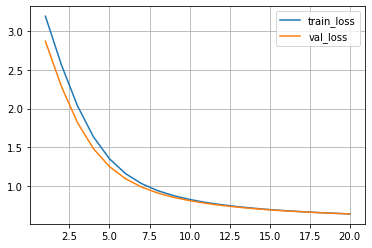

In [ ]:
import matplotlib.pyplot as plt

epochs = [x for x in range(1, len(history['train_loss'])+1)]
plt.plot(epochs, history['train_loss'], label='train_loss')
plt.plot(epochs, history['val_loss'], label='val_loss')
plt.grid('both')
plt.legend()
plt.plot()

[]

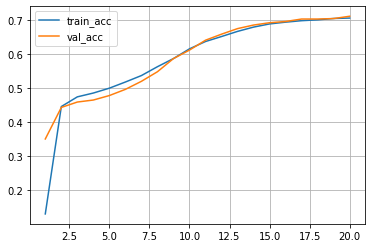

In [ ]:
epochs = [x for x in range(1, len(history['train_acc'])+1)]
plt.plot(epochs, history['train_acc'], label='train_acc')
plt.plot(epochs, history['val_acc'], label='val_acc')
plt.grid('both')
plt.legend()
plt.plot()

In [ ]:
anti_string = 'I like the UK, but Brexit will not be good in the long run'
pro_string = 'The UK should leave the EU'

def single_prediction(sentence):
    # NOTE: A dummy label must be supplied in order to reuse the methods of the
    # preprocessor
    dummy_label = 'pro'
    # Create a tokenized version of the test string
    encoded = preprocessor.encode([sentence], [dummy_label])
    # Create the Pytorch tensors for the model
    X, _ = preprocessor.make_batch_tensors([*encoded])
    # Run the model and get the prediction as a numpy array
    Y = model(X).argmax(dim=1).detach().cpu().numpy()
    # Finally, decode the prediction using the preprocessor method
    return preprocessor.decode_predictions(Y)[0]

prediction = single_prediction(anti_string)
print(f'The sentence: "{anti_string}", is {prediction.upper()}-Brexit.')
prediction = single_prediction(pro_string)
print(f'The sentence: "{pro_string}", is {prediction.upper()}-Brexit.')

The sentence: "I like the UK, but Brexit will not be good in the long run", is ANTI-Brexit.
The sentence: "The UK should leave the EU", is PRO-Brexit.


In [ ]:
single_prediction("the prime minister of uk is doing a good job")

'pro'

In [ ]:
test_corpus = pd.read_csv('brexit_test.tsv', sep='\t', header=0, names=['label', 'text'])
X, Y = list(test_corpus.text), list(test_corpus.label)

encoded_test = preprocessor.encode(X, Y)
# NOTE: We are vstacking the predictions of each batch, but the last batch might
# have a different dimension from all the previous ones. Hence, we use a batch
# size of 1. Alternatively, one could use the great common divider of the length
# of the encoded_test.
data_test = DataLoader(encoded_test, batch_size=1, shuffle=False,
                       collate_fn=preprocessor.make_batch_tensors)

outputs, accuracy = predict(model, data_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

Test accuracy: 70.47%
